In [46]:
import wandb
import pandas as pd
from IPython.display import display
api = wandb.Api()
sweep = api.sweep("dpfrommer-projects/stanza/gdv234qy")

data = []
for r in sweep.runs:
    if "test_reward" not in r.summary:
        continue
    d = {
        "num_traj": r.config["num_trajectories"],
        "sigma": r.config["smoothing_sigma"],
        "gains": r.config["diffuse_gains"] == True,
        "entrypoint": "diffusion" if "diffusion_bc" in r.config["entrypoint"] else "bc",
        "test_reward": r.summary["test_reward"],
        "rng_seed": r.config["rng_seed"]
    }
    data.append(d)
data = pd.DataFrame(data)
display(data)


,num_traj,sigma,gains,entrypoint,test_reward,rng_seed
0,10,0.050,False,diffusion,0.023200,46
1,10,0.030,False,diffusion,0.041659,46
2,10,0.010,False,diffusion,0.616500,46
3,10,0.005,False,diffusion,0.865087,46
4,10,0.000,False,diffusion,0.890216,46
...,...,...,...,...,...,...
295,1,0.050,True,diffusion,0.467562,42
296,1,0.030,True,diffusion,0.461236,42
297,1,0.010,True,diffusion,0.215549,42
298,1,0.005,True,diffusion,0.145155,42


In [47]:

import matplotlib.pyplot as plt
import seaborn as sns
import itertools
colors = list(sns.color_palette("Set2")) + list(sns.color_palette("Set1"))
#colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for (r,g,b) in colors]
#colors_dark = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for (r,g,b) in colors_dark]
markers = ["circle", "square", "triangle-up", "diamond", "cross"]
sns.set_theme(style="darkgrid")

def plot(data, x, ys, consolidate=["rng_seed"], style_func=lambda series, y: {}):
  # average over the ys
  groupby = list(set(data.columns) - set(ys) - set(consolidate))
  groups = data.groupby(groupby, group_keys=True)
  mean = groups.mean().reset_index()
  std = groups.std().reset_index()
  # group mean, std by things that are not
  # x or ys
  groupby = list(set(data.columns) - set([x] + ys + consolidate))
  mean = mean.groupby(groupby, group_keys=True)
  std = std.groupby(groupby, group_keys=True)

  # precompute all of the styles
  color_vals = set()
  for series, _ in mean:
    series = dict(zip(groupby, series))
    for y in ys:
      style = style_func(series, y)
      color_vals.add(style["color_key"])
  
  # hash the color vals to the colors
  color_map = {k: v for k, v in zip(color_vals, itertools.cycle(colors))}

  for (series, m), (_, s) in zip(mean,std):
    series = dict(zip(groupby, series))
    x_vals = m[x].to_numpy()
    for y in ys:
      y_vals = m[y].to_numpy()
      y_err_vals = s[y].to_numpy()

      style = style_func(series, y)
      color_key = style["color_key"]
      del style["color_key"]
      color = color_map[color_key]
      if "color_mod" in style:
        color_mod = style["color_mod"]
        del style["color_mod"]
        color = color_mod(color)

      plt.plot(x_vals, y_vals, color=color, **style)
      plt.fill_between(x_vals, y_vals - y_err_vals, y_vals + y_err_vals, color=color, alpha=0.2)
  plt.legend(loc="lower right")

Text(0, 0.5, 'Normalized Reward')

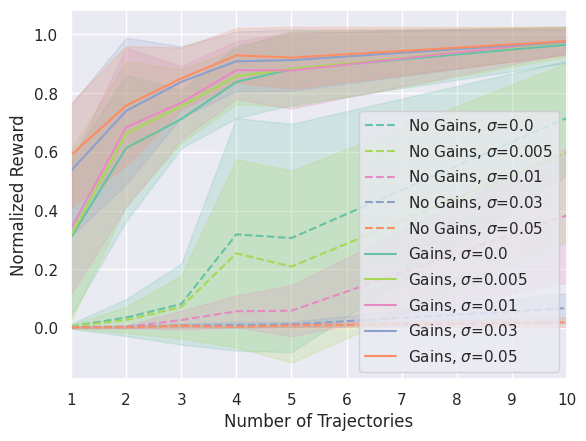

In [52]:
def style(series, y):
    gains = "Gains, " if series["gains"] else "No Gains, "
    sigma = series["sigma"]
    return {
        "label": f"{gains}$\sigma$={sigma}",
        "color_key": sigma,
        "linestyle": "-" if series["gains"] else "--",
    }
# filtered_data = data[data["lambda"] < 0.1]
filtered_data = data
# filtered_data = filtered_data[filtered_data["sigma"].isin([0., 0.01, 0.1, 0.3])]
plot(filtered_data, "num_traj", ["test_reward"], style_func=style)
plt.xlim([1, 10])
# plt.xticks([5, 15, 30, 45, 60])
plt.xlabel("Number of Trajectories")
plt.ylabel("Normalized Reward")

Text(0, 0.5, 'Normalized Reward')

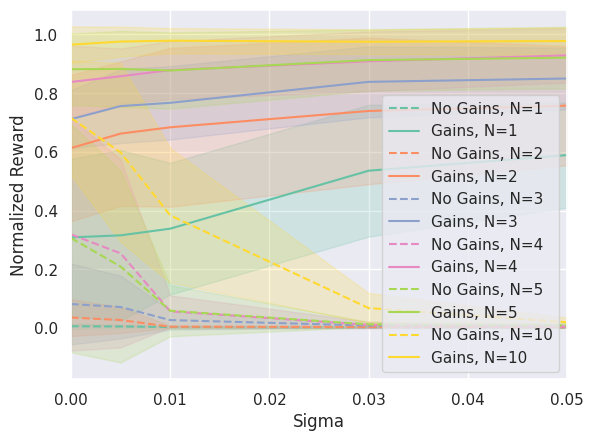

In [54]:
def style(series, y):
    gains = "Gains, " if series["gains"] else "No Gains, "
    N = series["num_traj"]
    return {
        "label": f"{gains}N={N}",
        "color_key": series["num_traj"],
        "linestyle": "-" if series["gains"] else "--",
    }

filtered_data = data
filtered_data = filtered_data[filtered_data["num_traj"].isin([1, 3, 5, 10])]
plot(filtered_data, "sigma", ["test_reward"], style_func=style)
plt.xlabel("Sigma")
plt.xlim([0, 0.05])
plt.ylabel("Normalized Reward")